<a href="https://www.dask.org/" target="_blank">
<img src="http://dask.readthedocs.io/en/latest/_images/dask_horizontal.svg"
     align="right"
     width="30%"
     alt="Dask logo\">
</a>

# Use case: Satellite Image Processing

This notebook will guide us through a practical use case example of Dask in satellite image processing.

**Introduction**

In satellite image processing, vegetation indices are the result of arithmetically operating the spectral components (bands) of a satellite image. The value of these indices, in most cases, enhances the phenological properties of the crops. Examples of vegetation indices used recurrently in the literature for crop analysis are **Normalized Difference Vegetation Index (NDVI)**, and **Enhanced Vegetation Index (EVI)**. Other vegetation indices found in the literature are **Ratio Vegetation Index (RVI)** and **Soil Adjusted Vegetation Index (SAVI)**. You can find more information about indexes


<center>
<img src="img/ndvi.png" width="80%"/>
</center>
<center>
<a href="https://www.agricolus.com/en/vegetation-indices-ndvi-ndmi/" target="_blank" width="30%"> Example NDVI (Normalized Difference Vegetation Index) </a>
</center>



**Content**

1. Prepare Satellite Image
2. Prepare the High-Performance Computing System
3. Release the resources reserved on the High-Performance Computing System

## 1. Prepare Satellite Image

__1. Import required libraries__

In [1]:
import os, zipfile, glob, rioxarray

download_storage    = './download_storage'
images_storage      = './images_storage'

__2. Copy the image into your working directory__

In [2]:
!cp /home/carla1/S2A_MSIL2A_20200205T151701_N0214_R125_T18NYM_20200205T191802.zip download_storage

__3. Unzip the image into__

In [ ]:
for zip_file in glob.glob(f"{download_storage}/*.zip"):
    with zipfile.ZipFile(zip_file) as zip_ref:
        dst_folder = os.path.basename(zip_file).replace('.zip','.SAFE')
        if not os.path.exists(os.path.join(images_storage, dst_folder)):
            zip_ref.extractall(images_storage)

__4. Load the image bands__

In [49]:
band_rgb = rioxarray.open_rasterio('./images_storage/S2A_MSIL2A_20200205T151701_N0214_R125_T18NYM_20200205T191802.SAFE/GRANULE/L2A_T18NYM_A024146_20200205T151919/IMG_DATA/R10m/T18NYM_20200205T151701_TCI_10m.jp2')
band_red = rioxarray.open_rasterio('./images_storage/S2A_MSIL2A_20200205T151701_N0214_R125_T18NYM_20200205T191802.SAFE/GRANULE/L2A_T18NYM_A024146_20200205T151919/IMG_DATA/R10m/T18NYM_20200205T151701_B04_10m.jp2')
band_nir = rioxarray.open_rasterio('./images_storage/S2A_MSIL2A_20200205T151701_N0214_R125_T18NYM_20200205T191802.SAFE/GRANULE/L2A_T18NYM_A024146_20200205T151919/IMG_DATA/R10m/T18NYM_20200205T151701_B08_10m.jp2')

rgb = band_rgb.isel(x=slice(10000,20000), y=slice(10000,20000))
red = band_red.isel(x=slice(10000,20000), y=slice(10000,20000))
nir = band_nir.isel(x=slice(10000,20000), y=slice(10000,20000))

del band_rgb
del band_red
del band_nir

__5. Plot the RGB compisition__

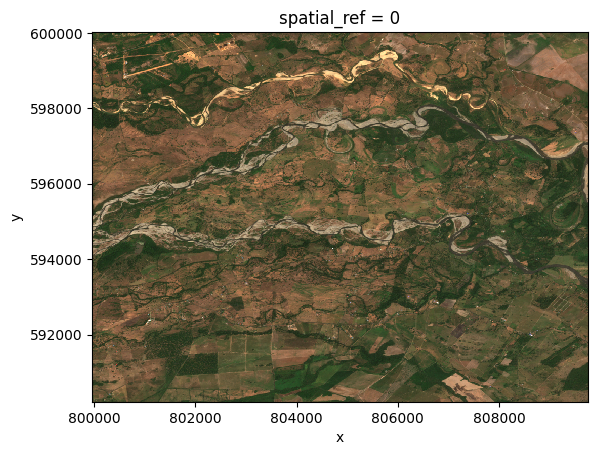

In [45]:
rgb.plot.imshow()

__6. Plot the RED band__

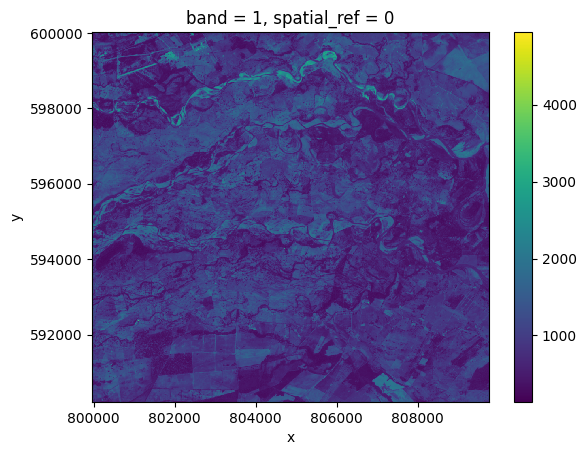

In [47]:
red.plot()

__7. Plot the NIR (Near Infrared) band__

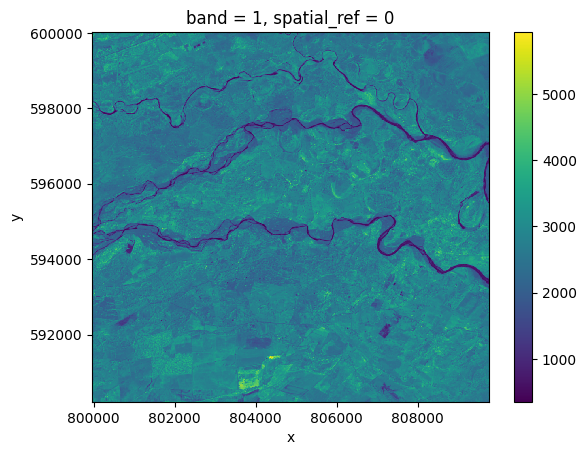

In [48]:
nir.plot()

__8. Chunk the bands in order to enable Dask's computations in the arrays__

In [51]:
chunked_red = red.chunk({'x':100, 'y':100})
chunked_nir = nir.chunk({'x':100, 'y':100})

del red 
del nir

__9. `DEFINE` the NDVI (Normalized Difference Vegetation Index) computation__

The NDVI is used to rate the greenness of vegetation and is useful to evaluate its density and health; For this index, values close to 1 correspond to dense vegetation, such as that found in forests or crops in their maximum growth stage, while values close to 0 represent areas with scarce vegetation. Finally, negative values close to -1 represent indications of water.

The equation that allows the calculation of this index is shown below:

```sh
NDVI = (NIR - RED) / (NIR + RED)
```

In [52]:
ndvi = (chunked_nir - chunked_red) / (chunked_nir + chunked_red)
ndvi

<xarray.DataArray (band: 1, y: 980, x: 980)>
dask.array<truediv, shape=(1, 980, 980), dtype=float64, chunksize=(1, 100, 100), chunktype=numpy.ndarray>
Coordinates:
  * band         (band) int64 1
  * x            (x) float64 8e+05 8e+05 8e+05 ... 8.097e+05 8.097e+05 8.098e+05
  * y            (y) float64 6e+05 6e+05 6e+05 ... 5.902e+05 5.902e+05 5.902e+05
    spatial_ref  int64 0

## 2. Prepare the High-Performance Computing System

* High-Performance Computing (HPC) systems are **tightly coupled, custom, specialized computers**. The primary objective is to **accelerate numerical analysis at a large scale**. However, in the last years, supercomputers have been adapted to comply with both numerical and data analysis. 
* Dask can be deployed in an HPC system to perform large-scale data analysis. Depending on how Dask was configured in the HPC, it will bring significant advantages in communication-intensive computations.

| Diagram                                                                                                                             | High Performance Computing System (El Capitan)                                                                                                                             |
|-----------------------------------------------------------------------------------------------------------------------------------|-----------------------------------------------------------------------------------------------------------------------------------|
|                                                         |
| <img src="img/dask-arch.svg" width="600px"> | <img src="img/hpc_el_capitan.jpeg" width="600px"> |
<center>

</center>

__1. Import required libraries, define required variables and functions__

In [53]:
from dask_jobqueue import SLURMCluster
from dask.distributed import Client

__2. Create a Dask cluster__

_Hint: Here you will define how namy `cores` and `memory` will have every Dask worker._

In [54]:
cluster = SLURMCluster(
    name=#...,
    cores=1,
    memory="8GB",
    processes=True,
    scheduler_options={"dashboard_address": ":0"}
)

cluster

Dashboard: http://192.5.86.235:43513/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://192.168.0.50:37713,Workers: 0
Dashboard: http://192.5.86.235:43513/status,Total threads: 0
Started: Just now,Total memory: 0 B


__3. Create a Dask Client and connect the client to the Dask cluster in the High Performance Computing System__

_Activities:_ 

1. Run the cell below
2. Use the option `Launch dashboard in JupyterLab`, this will display the Dask Dashboard.

In [55]:
client = Client(cluster)  # Connect to distributed cluster and override default
client

Connection method: Cluster object,Cluster type: dask_jobqueue.SLURMCluster
Dashboard: http://192.5.86.235:43513/status,
Dashboard: http://192.5.86.235:43513/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://192.168.0.50:37713,Workers: 0
Dashboard: http://192.5.86.235:43513/status,Total threads: 0
Started: Just now,Total memory: 0 B


__4. Deploy workers for your Dask cluster__

_Hint: each worker will be a slurm job._

In [56]:
cluster.scale(jobs=2)

__5. Adjust the number of workers according to the workload__

_Hint: This also works with adaptive clusters. This automatically launches and kill workers based on load [7]._

In [ ]:
# DANGEROUS ZONE, PLEASE DO NOT USE IT, THIS WILL BE EXECUTED BY THE INSTRUCTOR
# cluster.adapt(minimum=1, maximum=4)

__6. `COMPUTE` the NDVI__

_Hint: Use the Dashboard to see what is happening while your computation is taking place._

In [58]:
result = ndvi.compute()
result

<xarray.DataArray (band: 1, y: 980, x: 980)>
array([[[0.74361851, 0.8074037 , 0.81183317, ..., 0.62374627,
         0.62496651, 0.6039823 ],
        [0.783545  , 0.74478902, 0.73794212, ..., 0.61048894,
         0.62646745, 0.61334056],
        [0.76972281, 0.74017642, 0.74896323, ..., 0.58826816,
         0.59748771, 0.60673547],
        ...,
        [0.45045593, 0.44385655, 0.51219512, ..., 0.52431477,
         0.48637016, 0.4518606 ],
        [0.45745288, 0.45618994, 0.51389279, ..., 0.51746404,
         0.50512528, 0.48446632],
        [0.46198507, 0.47268673, 0.47061995, ..., 0.48056191,
         0.50157729, 0.47159289]]])
Coordinates:
  * band         (band) int64 1
  * x            (x) float64 8e+05 8e+05 8e+05 ... 8.097e+05 8.097e+05 8.098e+05
  * y            (y) float64 6e+05 6e+05 6e+05 ... 5.902e+05 5.902e+05 5.902e+05
    spatial_ref  int64 0

__7. Plot results__

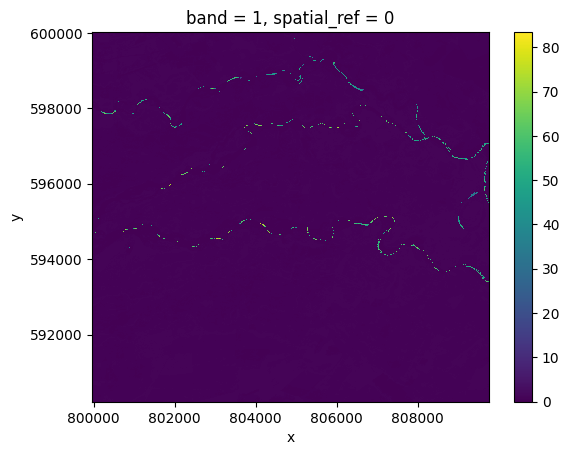

In [59]:
result.plot()

**NOTE:** The image above seems to not reflect the NDVI results we expect. In the first instance, the color bar shows that the calculated ndvi varies between 0 and 600. However, according to the literature, the ndvi calculation provides values that vary between -1.0 and 1.0. On the other hand, the image becomes a single color.

When dealing with satellite images it is common to find invalid pixel values, that is, 1) pixels with values that are outside the valid range of band values, (2) pixels that have no information, (3) pixels that have thin clouds that are not visible to the naked eye or due to the level of detail in the image it becomes imperceptible, among other cases. Given the above, it is prudent to remove these pixels from the original analysis to avoid the propagation of invalid pixel values.

__Masking invalid pixels__

Masking is the process of eliminating or removing invalid pixel information from the image to avoid propagating errors when making calculations with these values. One way to mask the image is to use the ranges of known NDVI values as criteria for acceptance or elimination of pixels.

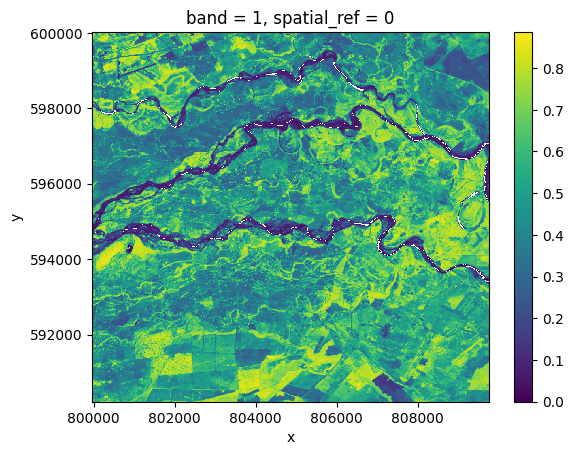

In [61]:
# Generación de máscara que establece que deseamos dejar aquellos píxeles que presentan un ndvi mayor que -1.0
mask_lower = result >= -1.0

# Generación de máscara que establece que deseamos dejar aquellos píxeles que son menores que 1.0
mask_higher = result <= 1.0

# Aplicamos ambas máscaras sobre todo el dataset
masked_result = result.where(mask_lower & mask_higher)

# Imágen del ndvi después de haber removido los valores inválidos para el índice
masked_result.plot()

__Define different colors for set ranges of values__

In some cases, it is necessary to establish specific colors for certain ranges of values that allow us to distinguish specific aspects of the coverage studied. The code shown below sets specific colors for defined ranges of ndvi values.

Reference: the colors used in the color bar were taken from *[A repository of custom scripts that can be used with Sentinel-Hub services](https://custom-scripts.sentinel-hub.com/custom-scripts/sentinel-2/ndvi/)*

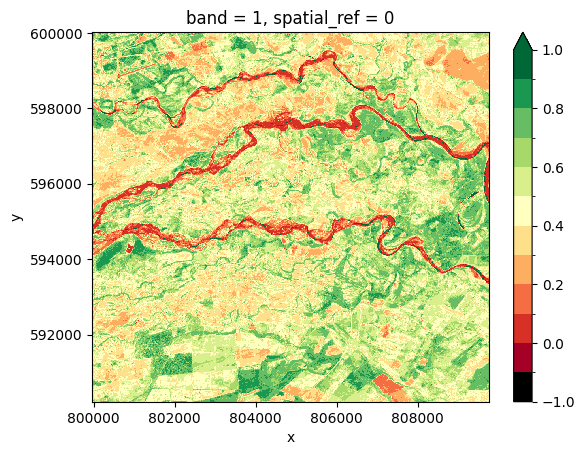

In [67]:
import matplotlib as mpl

cmap = mpl.colors.ListedColormap(
    [
        '#000000', 
        '#a50026',
        '#d73027',
        '#f46d43',
        '#fdae61',
        '#fee08b',
        '#ffffbf',
        '#d9ef8b',
        '#a6d96a',
        '#66bd63',
        '#1a9850',
        '#006837'
    ]
)

# Rangos de valores establecidos
bounds = [-1.0, -0.2, 0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

# Genera una capa de normalización de los datos basada en los intérvalos establecidos en 'bounds'
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

# Mostrar imágen de la variable de datos ndvi.
result.plot(cmap=cmap,norm=norm)

## 3. Release the resources reserved on the High-Performance Computing System

__7. Showdown the cluster__

In [ ]:
cluster.close()

__9. Close the connection between the client and the cluster__

In [ ]:
client.close()